# LINCS 2020 训练数据集全面可视化分析

本notebook提供DrugReflector训练数据的全面可视化分析，包括：
1. 数据集基本统计
2. 化合物和样本分布
3. 细胞系分布
4. 化学过滤效果对比
5. 交叉验证fold分布
6. 基因表达特征分析
7. 与论文数据对比

In [1]:
# 导入所有需要的库
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 1. 加载数据

In [2]:
# 配置路径
data_dir = "E:/科研/Models/drugreflector/processed_data"

# 加载过滤前后的数据
print("📖 Loading datasets...\n")

# 基础过滤后的数据（未经化学过滤）
data_basic_path = Path(data_dir) / "training_data_lincs2020_25111801.pkl"
with open(data_basic_path, 'rb') as f:
    data_basic = pickle.load(f)

print(f"✓ Loaded basic filtered data:")
print(f"  Samples: {len(data_basic['X']):,}")
print(f"  Compounds: {len(data_basic['compound_names']):,}")
print(f"  Features: {data_basic['X'].shape[1]}")

# 化学过滤后的最终数据
data_final_path = Path(data_dir) / "training_data_lincs2020_final_25111801.pkl"
with open(data_final_path, 'rb') as f:
    data_final = pickle.load(f)

print(f"\n✓ Loaded final filtered data:")
print(f"  Samples: {len(data_final['X']):,}")
print(f"  Compounds: {len(data_final['compound_names']):,}")
print(f"  Features: {data_final['X'].shape[1]}")

# 创建输出目录
viz_dir = Path("E:/科研/Models/drugreflector/visualizations")
viz_dir.mkdir(exist_ok=True, parents=True)
print(f"\n✓ Visualizations will be saved to: {viz_dir}")

📖 Loading datasets...

✓ Loaded basic filtered data:
  Samples: 474,098
  Compounds: 10,713
  Features: 978

✓ Loaded final filtered data:
  Samples: 255,928
  Compounds: 6,971
  Features: 978

✓ Visualizations will be saved to: E:\科研\Models\drugreflector\visualizations


## 2. 数据集基本统计

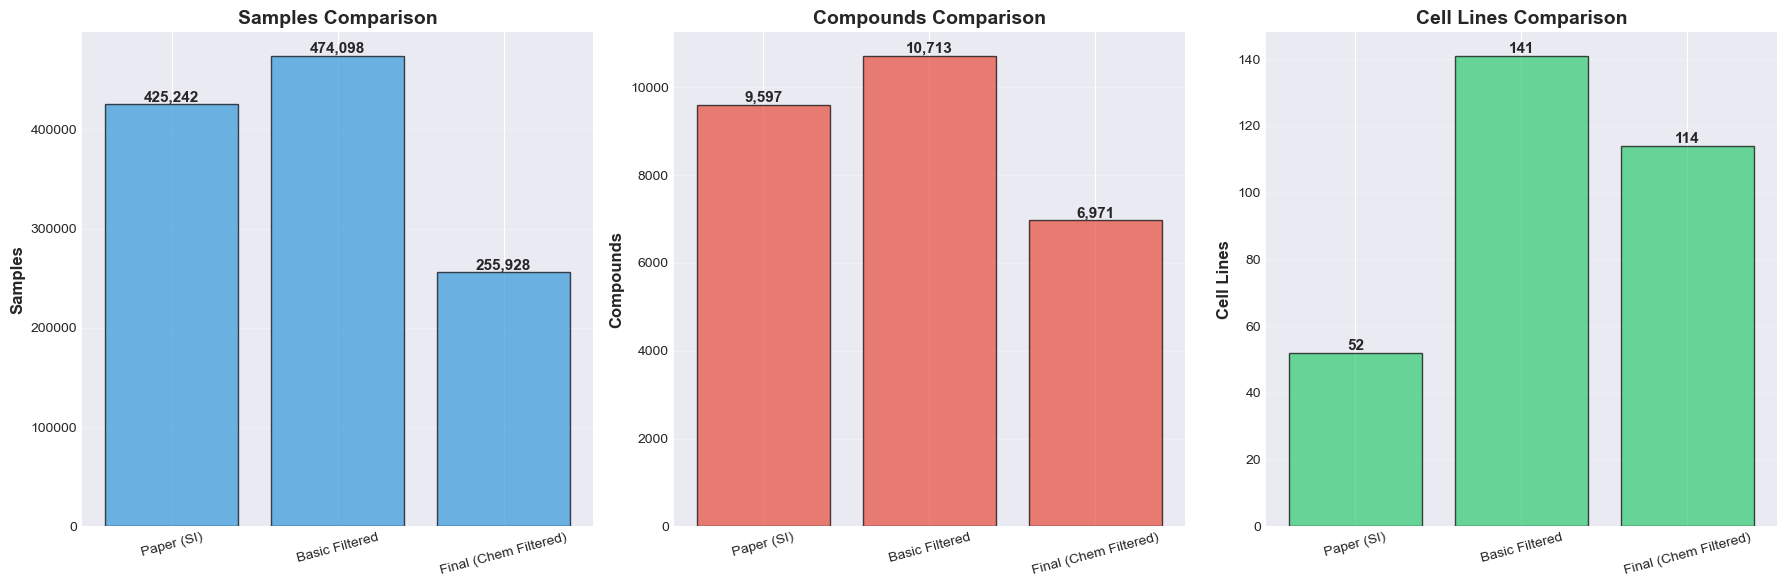


📊 Dataset Statistics:
              Dataset  Samples  Compounds  Cell Lines
           Paper (SI)   425242       9597          52
       Basic Filtered   474098      10713         141
Final (Chem Filtered)   255928       6971         114

📈 Retention Rates (vs Paper):
  Basic Filtered:
    Samples: 111.5%
    Compounds: 111.6%
  Final Filtered:
    Samples: 60.2%
    Compounds: 72.6%


In [3]:
# 准备统计数据
stats_data = {
    'Dataset': ['Paper (SI)', 'Basic Filtered', 'Final (Chem Filtered)'],
    'Samples': [425242, len(data_basic['X']), len(data_final['X'])],
    'Compounds': [9597, len(data_basic['compound_names']), len(data_final['compound_names'])],
    'Cell Lines': [52, 
                   data_basic['sample_meta']['cell_iname'].nunique() if 'cell_iname' in data_basic['sample_meta'].columns else 0,
                   data_final['sample_meta']['cell_iname'].nunique() if 'cell_iname' in data_final['sample_meta'].columns else 0]
}

stats_df = pd.DataFrame(stats_data)

# 绘制对比图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics = ['Samples', 'Compounds', 'Cell Lines']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (ax, metric, color) in enumerate(zip(axes, metrics, colors)):
    bars = ax.bar(stats_df['Dataset'], stats_df[metric], color=color, alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    
    # 添加数值标签
    for bar, val in zip(bars, stats_df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,}',
                ha='center', va='bottom', fontweight='bold')
    
    # 旋转x轴标签
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig(viz_dir / '01_dataset_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Dataset Statistics:")
print(stats_df.to_string(index=False))

# 计算retention rates
print(f"\n📈 Retention Rates (vs Paper):")
print(f"  Basic Filtered:")
print(f"    Samples: {stats_df.iloc[1]['Samples']/stats_df.iloc[0]['Samples']*100:.1f}%")
print(f"    Compounds: {stats_df.iloc[1]['Compounds']/stats_df.iloc[0]['Compounds']*100:.1f}%")
print(f"  Final Filtered:")
print(f"    Samples: {stats_df.iloc[2]['Samples']/stats_df.iloc[0]['Samples']*100:.1f}%")
print(f"    Compounds: {stats_df.iloc[2]['Compounds']/stats_df.iloc[0]['Compounds']*100:.1f}%")

## 3. 化合物样本数分布

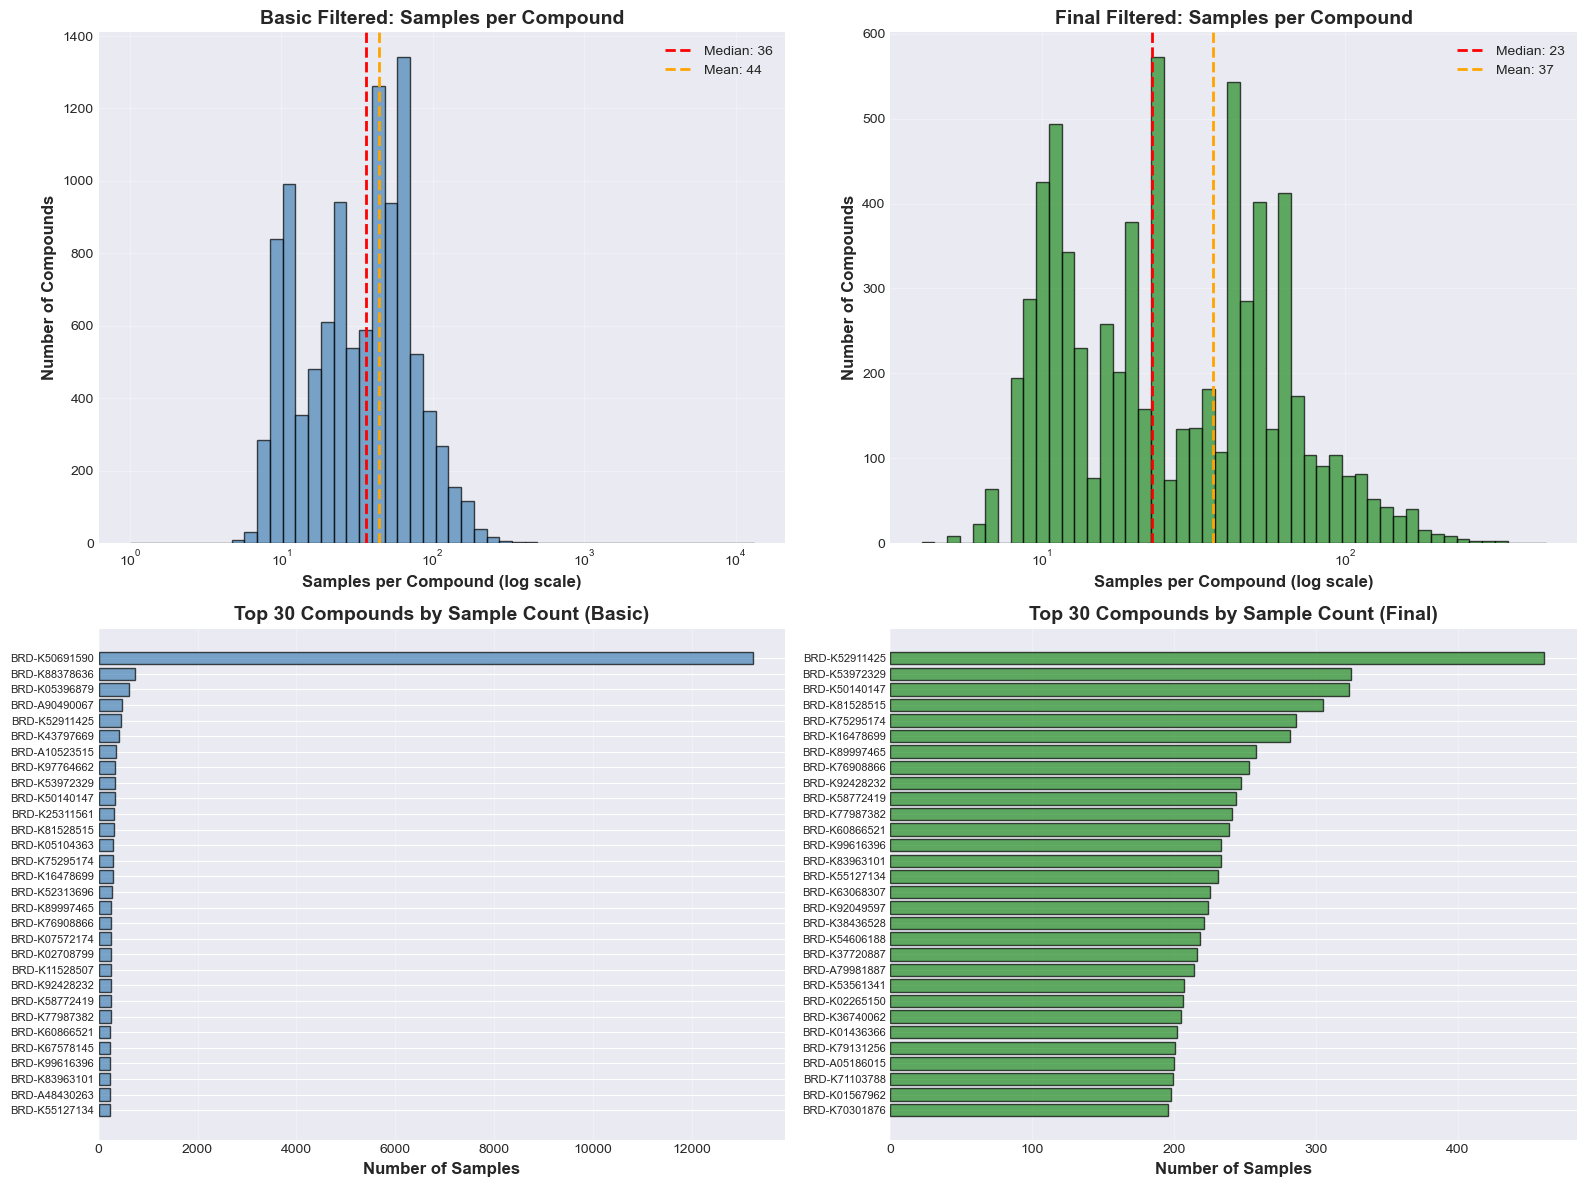


📊 Samples per Compound Statistics:

Basic Filtered:
  Mean: 44.3
  Median: 36
  Min: 1
  Max: 13223
  Compounds with >100 samples: 662

Final Filtered:
  Mean: 36.7
  Median: 23
  Min: 4
  Max: 461
  Compounds with >100 samples: 344


In [4]:
# 计算每个化合物的样本数
def get_compound_sample_counts(data):
    return data['sample_meta'].groupby('pert_id').size().sort_values(ascending=False)

basic_counts = get_compound_sample_counts(data_basic)
final_counts = get_compound_sample_counts(data_final)

# 创建4个子图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 子图1: 基础过滤 - 样本数分布直方图
ax = axes[0, 0]
bins = np.logspace(np.log10(basic_counts.min()), np.log10(basic_counts.max()), 50)
ax.hist(basic_counts.values, bins=bins, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xscale('log')
ax.set_xlabel('Samples per Compound (log scale)', fontweight='bold')
ax.set_ylabel('Number of Compounds', fontweight='bold')
ax.set_title('Basic Filtered: Samples per Compound', fontweight='bold')
ax.axvline(basic_counts.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {basic_counts.median():.0f}')
ax.axvline(basic_counts.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {basic_counts.mean():.0f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 子图2: 最终过滤 - 样本数分布直方图
ax = axes[0, 1]
bins = np.logspace(np.log10(final_counts.min()), np.log10(final_counts.max()), 50)
ax.hist(final_counts.values, bins=bins, color='forestgreen', alpha=0.7, edgecolor='black')
ax.set_xscale('log')
ax.set_xlabel('Samples per Compound (log scale)', fontweight='bold')
ax.set_ylabel('Number of Compounds', fontweight='bold')
ax.set_title('Final Filtered: Samples per Compound', fontweight='bold')
ax.axvline(final_counts.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {final_counts.median():.0f}')
ax.axvline(final_counts.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {final_counts.mean():.0f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 子图3: Top 30 化合物（基础过滤）
ax = axes[1, 0]
top_basic = basic_counts.head(30)
y_pos = np.arange(len(top_basic))
ax.barh(y_pos, top_basic.values, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{pid[:15]}..." if len(pid) > 15 else pid for pid in top_basic.index], fontsize=8)
ax.set_xlabel('Number of Samples', fontweight='bold')
ax.set_title('Top 30 Compounds by Sample Count (Basic)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# 子图4: Top 30 化合物（最终过滤）
ax = axes[1, 1]
top_final = final_counts.head(30)
y_pos = np.arange(len(top_final))
ax.barh(y_pos, top_final.values, color='forestgreen', alpha=0.7, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{pid[:15]}..." if len(pid) > 15 else pid for pid in top_final.index], fontsize=8)
ax.set_xlabel('Number of Samples', fontweight='bold')
ax.set_title('Top 30 Compounds by Sample Count (Final)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(viz_dir / '02_compound_sample_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印统计信息
print("\n📊 Samples per Compound Statistics:")
print(f"\nBasic Filtered:")
print(f"  Mean: {basic_counts.mean():.1f}")
print(f"  Median: {basic_counts.median():.0f}")
print(f"  Min: {basic_counts.min()}")
print(f"  Max: {basic_counts.max()}")
print(f"  Compounds with >100 samples: {(basic_counts > 100).sum()}")

print(f"\nFinal Filtered:")
print(f"  Mean: {final_counts.mean():.1f}")
print(f"  Median: {final_counts.median():.0f}")
print(f"  Min: {final_counts.min()}")
print(f"  Max: {final_counts.max()}")
print(f"  Compounds with >100 samples: {(final_counts > 100).sum()}")

## 4. 细胞系分布分析

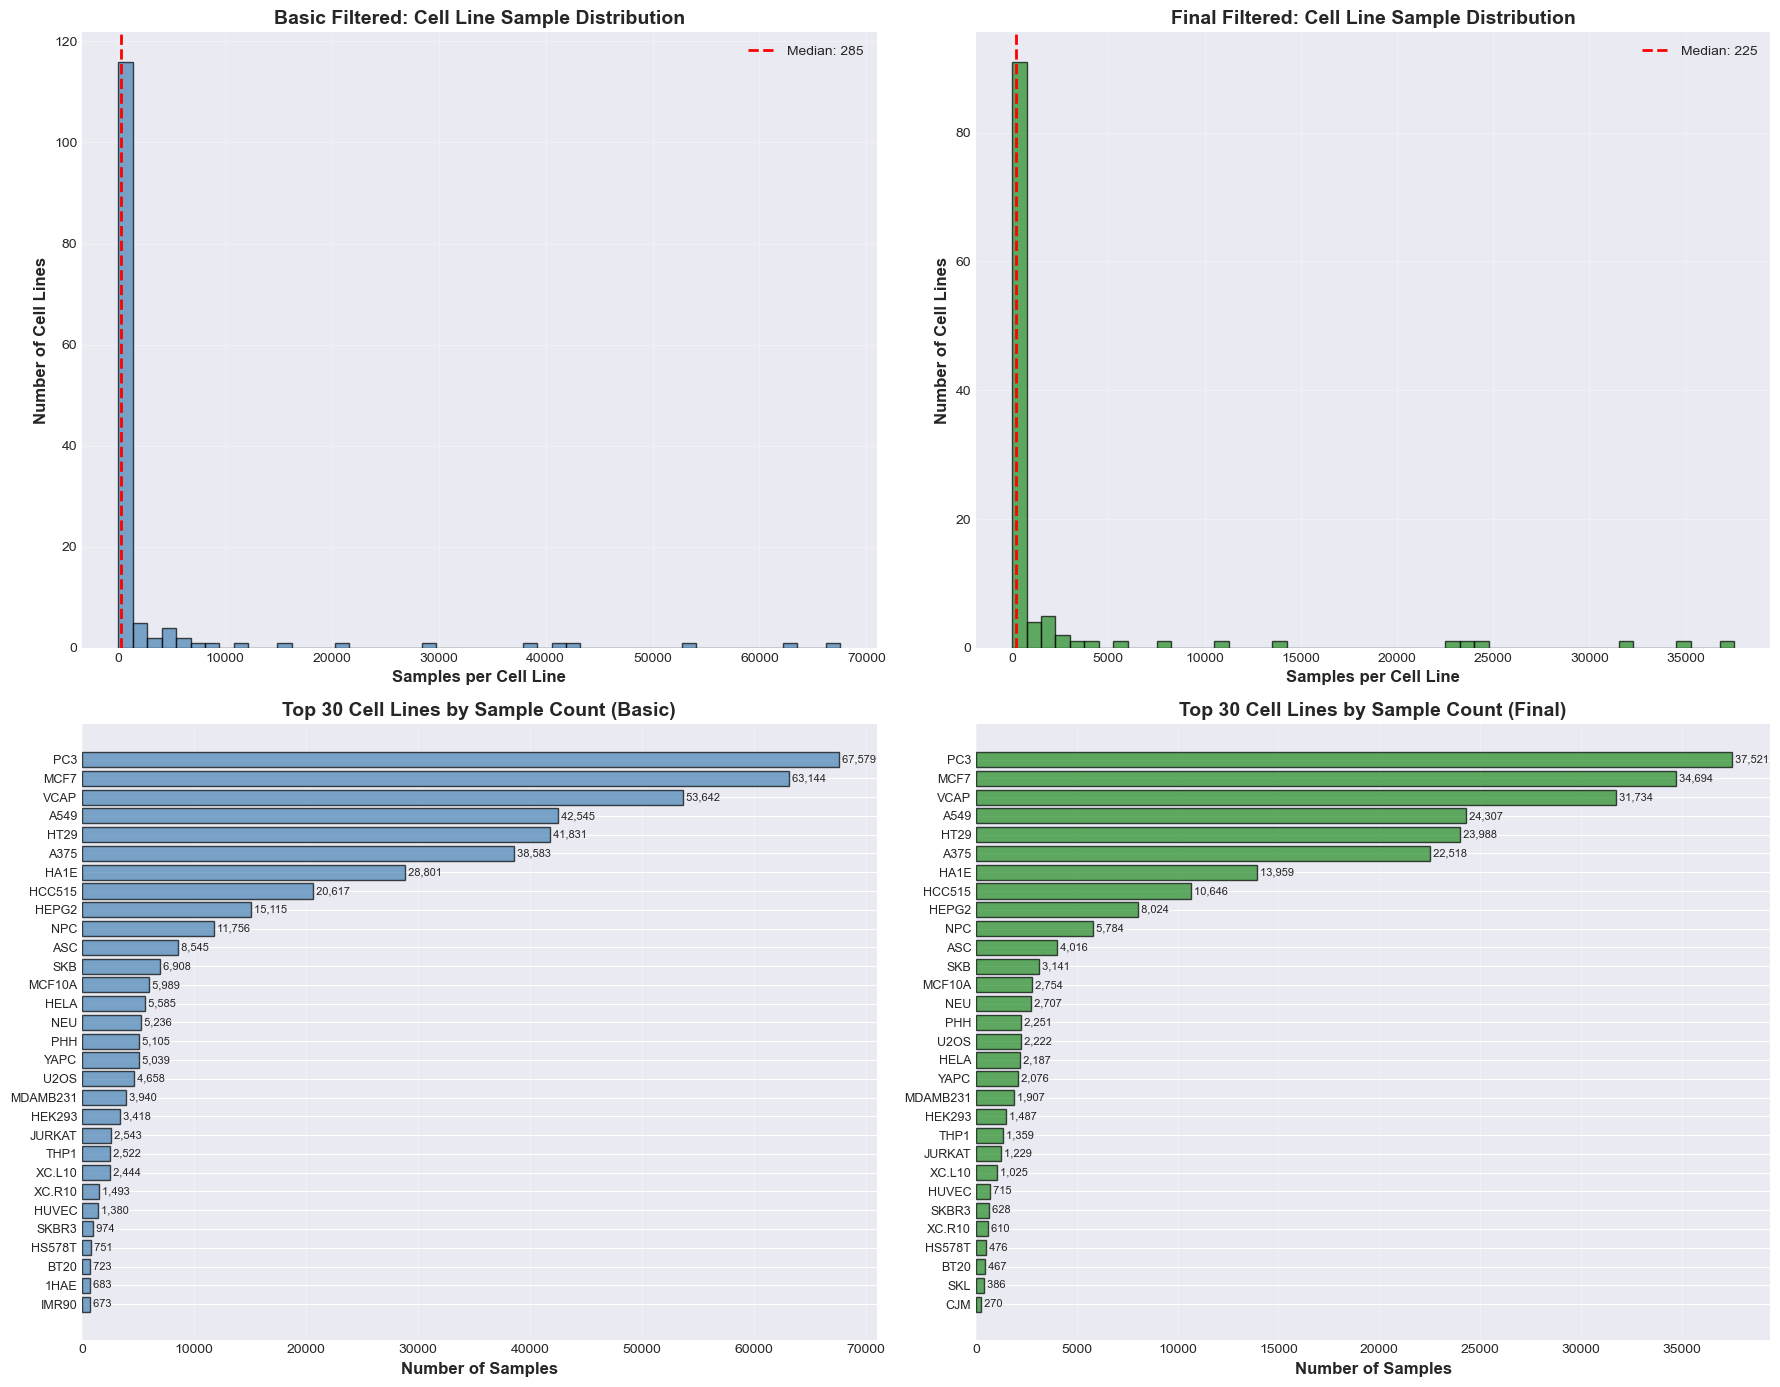


📊 Cell Line Statistics:

Basic Filtered:
  Total cell lines: 141
  Samples per cell (mean): 3362.4
  Samples per cell (median): 285
  Min samples: 1
  Max samples: 67579

Final Filtered:
  Total cell lines: 114
  Samples per cell (mean): 2245.0
  Samples per cell (median): 225
  Min samples: 3
  Max samples: 37521

⚠️  Cell lines removed by chemical filtering: 27


In [5]:
# 检查是否有细胞系信息
if 'cell_iname' not in data_basic['sample_meta'].columns:
    print("⚠️  Cell line information not available in metadata")
else:
    # 计算细胞系样本数
    basic_cell_counts = data_basic['sample_meta']['cell_iname'].value_counts()
    final_cell_counts = data_final['sample_meta']['cell_iname'].value_counts()
    
    # 创建2x2子图
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 子图1: 细胞系样本数分布（基础过滤）
    ax = axes[0, 0]
    ax.hist(basic_cell_counts.values, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Samples per Cell Line', fontweight='bold')
    ax.set_ylabel('Number of Cell Lines', fontweight='bold')
    ax.set_title('Basic Filtered: Cell Line Sample Distribution', fontweight='bold')
    ax.axvline(basic_cell_counts.median(), color='red', linestyle='--', linewidth=2, 
               label=f'Median: {basic_cell_counts.median():.0f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 子图2: 细胞系样本数分布（最终过滤）
    ax = axes[0, 1]
    ax.hist(final_cell_counts.values, bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Samples per Cell Line', fontweight='bold')
    ax.set_ylabel('Number of Cell Lines', fontweight='bold')
    ax.set_title('Final Filtered: Cell Line Sample Distribution', fontweight='bold')
    ax.axvline(final_cell_counts.median(), color='red', linestyle='--', linewidth=2, 
               label=f'Median: {final_cell_counts.median():.0f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 子图3: Top 30 细胞系（基础过滤）
    ax = axes[1, 0]
    top_basic_cells = basic_cell_counts.head(30)
    y_pos = np.arange(len(top_basic_cells))
    bars = ax.barh(y_pos, top_basic_cells.values, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_basic_cells.index, fontsize=9)
    ax.set_xlabel('Number of Samples', fontweight='bold')
    ax.set_title('Top 30 Cell Lines by Sample Count (Basic)', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    # 添加数值标签
    for i, (bar, val) in enumerate(zip(bars, top_basic_cells.values)):
        ax.text(val, i, f' {val:,}', va='center', fontsize=8)
    
    # 子图4: Top 30 细胞系（最终过滤）
    ax = axes[1, 1]
    top_final_cells = final_cell_counts.head(30)
    y_pos = np.arange(len(top_final_cells))
    bars = ax.barh(y_pos, top_final_cells.values, color='forestgreen', alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_final_cells.index, fontsize=9)
    ax.set_xlabel('Number of Samples', fontweight='bold')
    ax.set_title('Top 30 Cell Lines by Sample Count (Final)', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    # 添加数值标签
    for i, (bar, val) in enumerate(zip(bars, top_final_cells.values)):
        ax.text(val, i, f' {val:,}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(viz_dir / '03_cell_line_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印统计信息
    print("\n📊 Cell Line Statistics:")
    print(f"\nBasic Filtered:")
    print(f"  Total cell lines: {len(basic_cell_counts)}")
    print(f"  Samples per cell (mean): {basic_cell_counts.mean():.1f}")
    print(f"  Samples per cell (median): {basic_cell_counts.median():.0f}")
    print(f"  Min samples: {basic_cell_counts.min()}")
    print(f"  Max samples: {basic_cell_counts.max()}")
    
    print(f"\nFinal Filtered:")
    print(f"  Total cell lines: {len(final_cell_counts)}")
    print(f"  Samples per cell (mean): {final_cell_counts.mean():.1f}")
    print(f"  Samples per cell (median): {final_cell_counts.median():.0f}")
    print(f"  Min samples: {final_cell_counts.min()}")
    print(f"  Max samples: {final_cell_counts.max()}")
    
    # 检查哪些细胞系被化学过滤移除
    removed_cells = set(basic_cell_counts.index) - set(final_cell_counts.index)
    print(f"\n⚠️  Cell lines removed by chemical filtering: {len(removed_cells)}")
    if len(removed_cells) > 0 and len(removed_cells) <= 20:
        print(f"  Removed: {', '.join(sorted(removed_cells))}")

## 5. 化合物-细胞系覆盖度矩阵

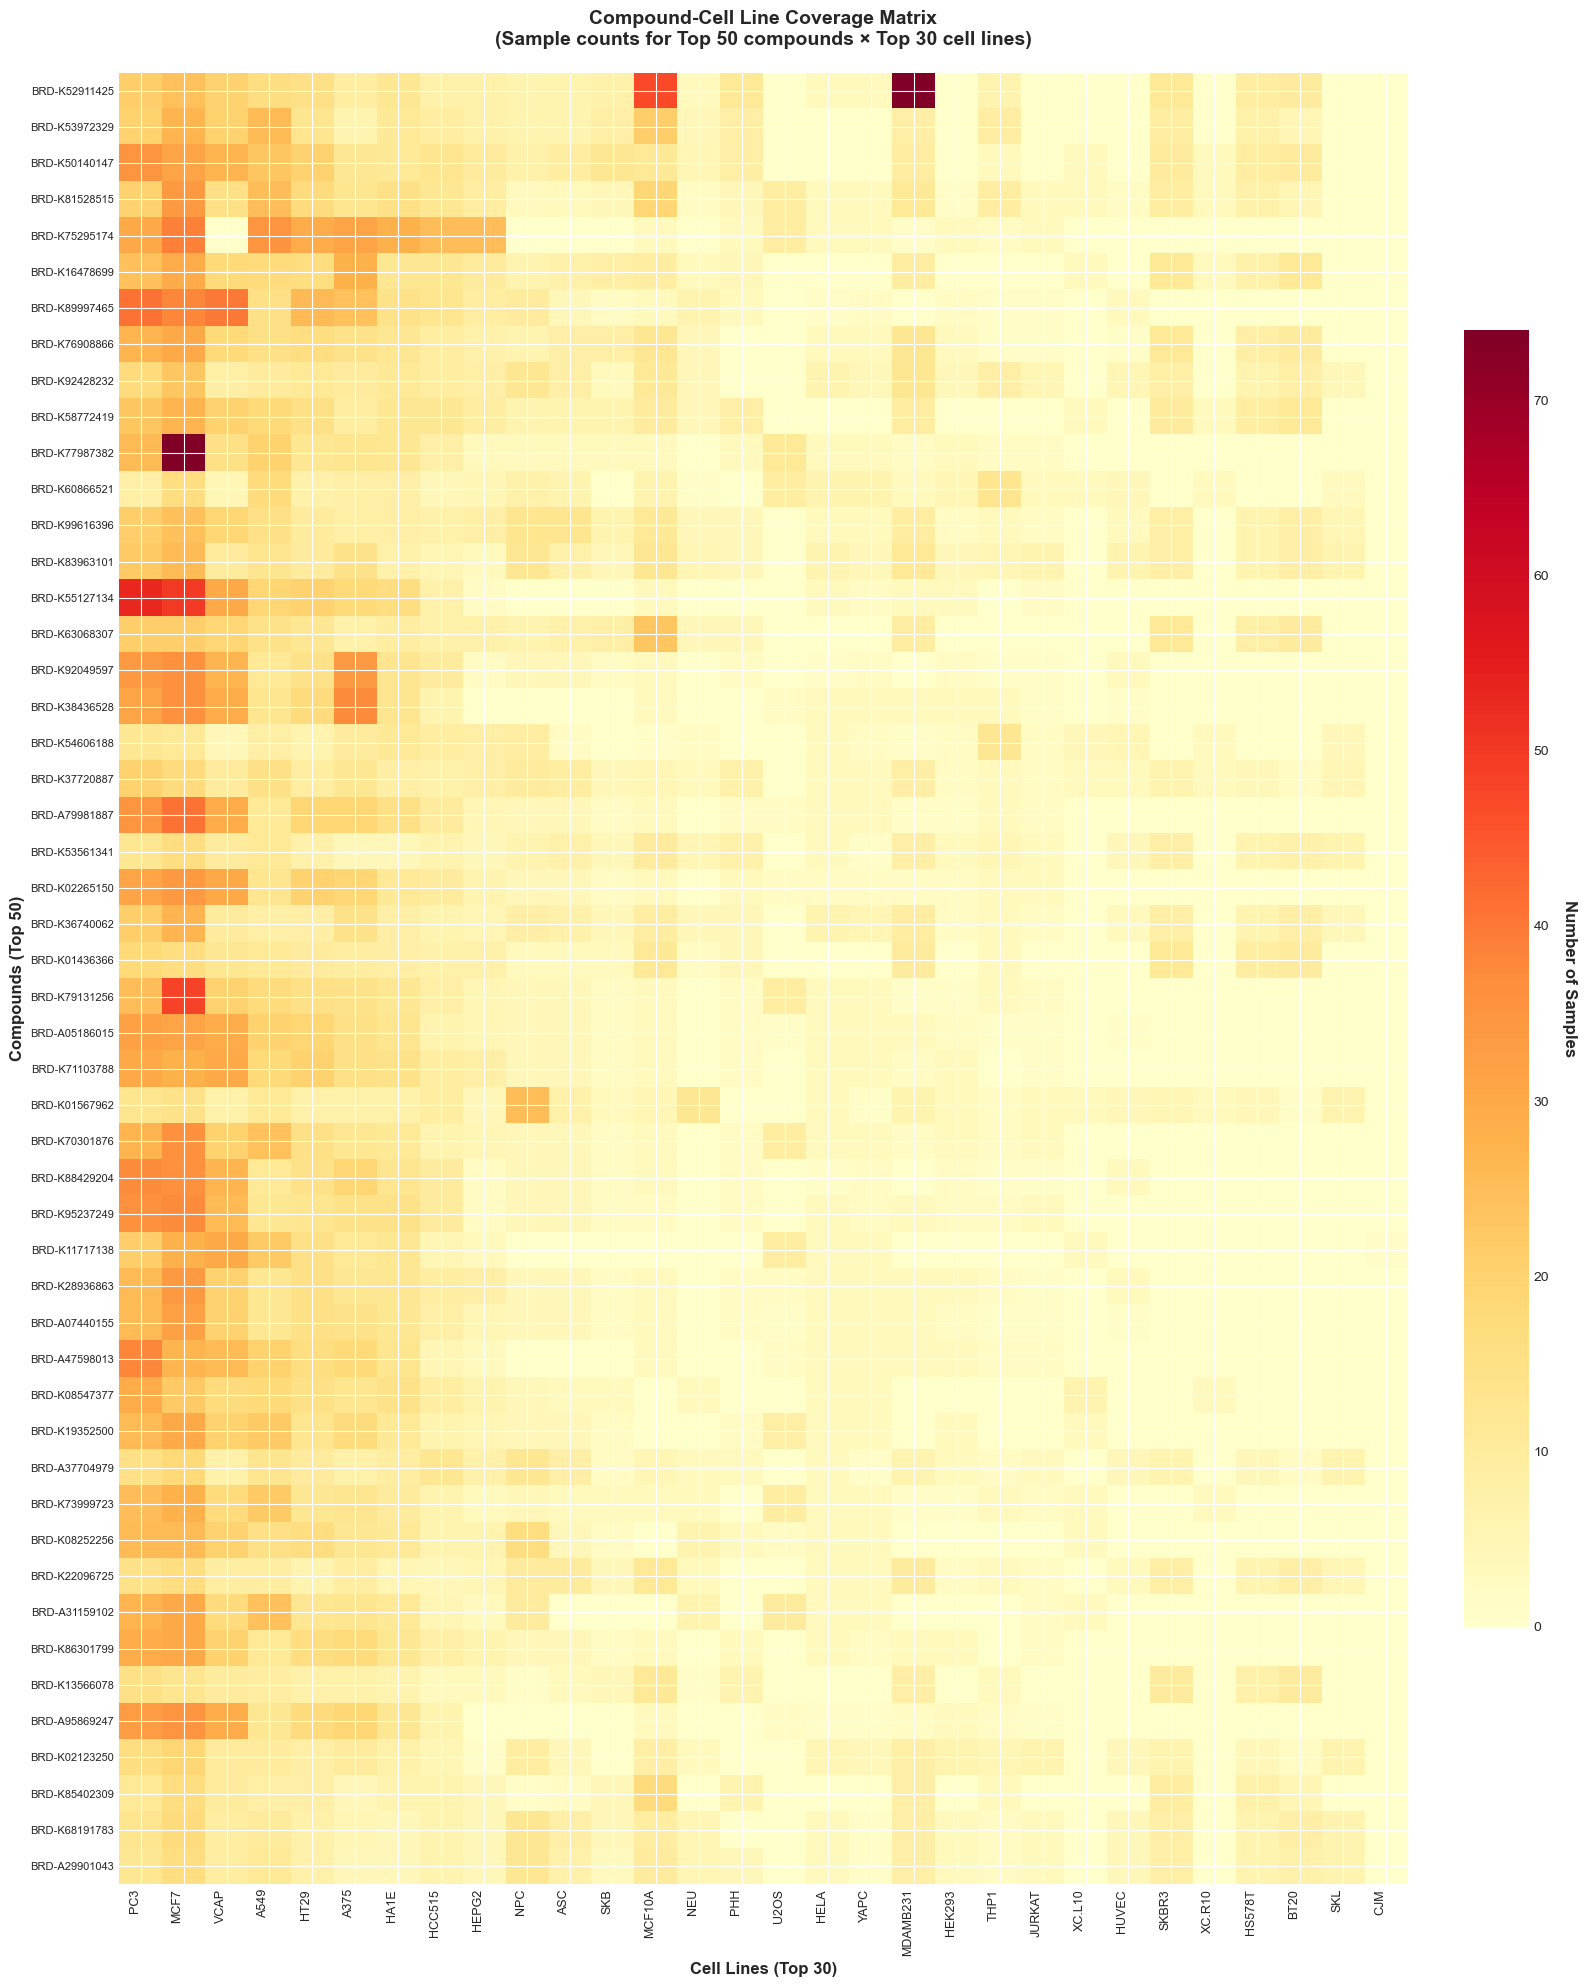


📊 Coverage Matrix Statistics:
  Matrix shape: (50, 30)
  Total entries: 1,500
  Non-zero entries: 1,071 (71.4%)
  Average samples per (compound, cell) pair: 9.3
  Max samples for a single pair: 74


In [6]:
if 'cell_iname' in data_final['sample_meta'].columns:
    # 选取样本数最多的前50个化合物和前30个细胞系
    top_compounds = final_counts.head(50).index
    top_cells = final_cell_counts.head(30).index
    
    # 创建覆盖度矩阵
    coverage_matrix = np.zeros((len(top_compounds), len(top_cells)))
    
    for i, compound in enumerate(top_compounds):
        compound_data = data_final['sample_meta'][data_final['sample_meta']['pert_id'] == compound]
        for j, cell in enumerate(top_cells):
            coverage_matrix[i, j] = (compound_data['cell_iname'] == cell).sum()
    
    # 绘制热图
    fig, ax = plt.subplots(figsize=(16, 20))
    
    im = ax.imshow(coverage_matrix, cmap='YlOrRd', aspect='auto', interpolation='nearest')
    
    # 设置坐标轴
    ax.set_xticks(np.arange(len(top_cells)))
    ax.set_yticks(np.arange(len(top_compounds)))
    ax.set_xticklabels(top_cells, rotation=90, ha='right', fontsize=9)
    ax.set_yticklabels([f"{c[:20]}..." if len(c) > 20 else c for c in top_compounds], fontsize=8)
    
    ax.set_xlabel('Cell Lines (Top 30)', fontweight='bold', fontsize=12)
    ax.set_ylabel('Compounds (Top 50)', fontweight='bold', fontsize=12)
    ax.set_title('Compound-Cell Line Coverage Matrix\n(Sample counts for Top 50 compounds × Top 30 cell lines)', 
                 fontweight='bold', fontsize=14, pad=20)
    
    # 添加colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Number of Samples', rotation=270, labelpad=20, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(viz_dir / '04_compound_cell_coverage_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 统计信息
    print(f"\n📊 Coverage Matrix Statistics:")
    print(f"  Matrix shape: {coverage_matrix.shape}")
    print(f"  Total entries: {coverage_matrix.size:,}")
    print(f"  Non-zero entries: {(coverage_matrix > 0).sum():,} ({(coverage_matrix > 0).sum()/coverage_matrix.size*100:.1f}%)")
    print(f"  Average samples per (compound, cell) pair: {coverage_matrix[coverage_matrix > 0].mean():.1f}")
    print(f"  Max samples for a single pair: {coverage_matrix.max():.0f}")
else:
    print("⚠️  Cell line information not available")

## 6. 交叉验证Fold分布

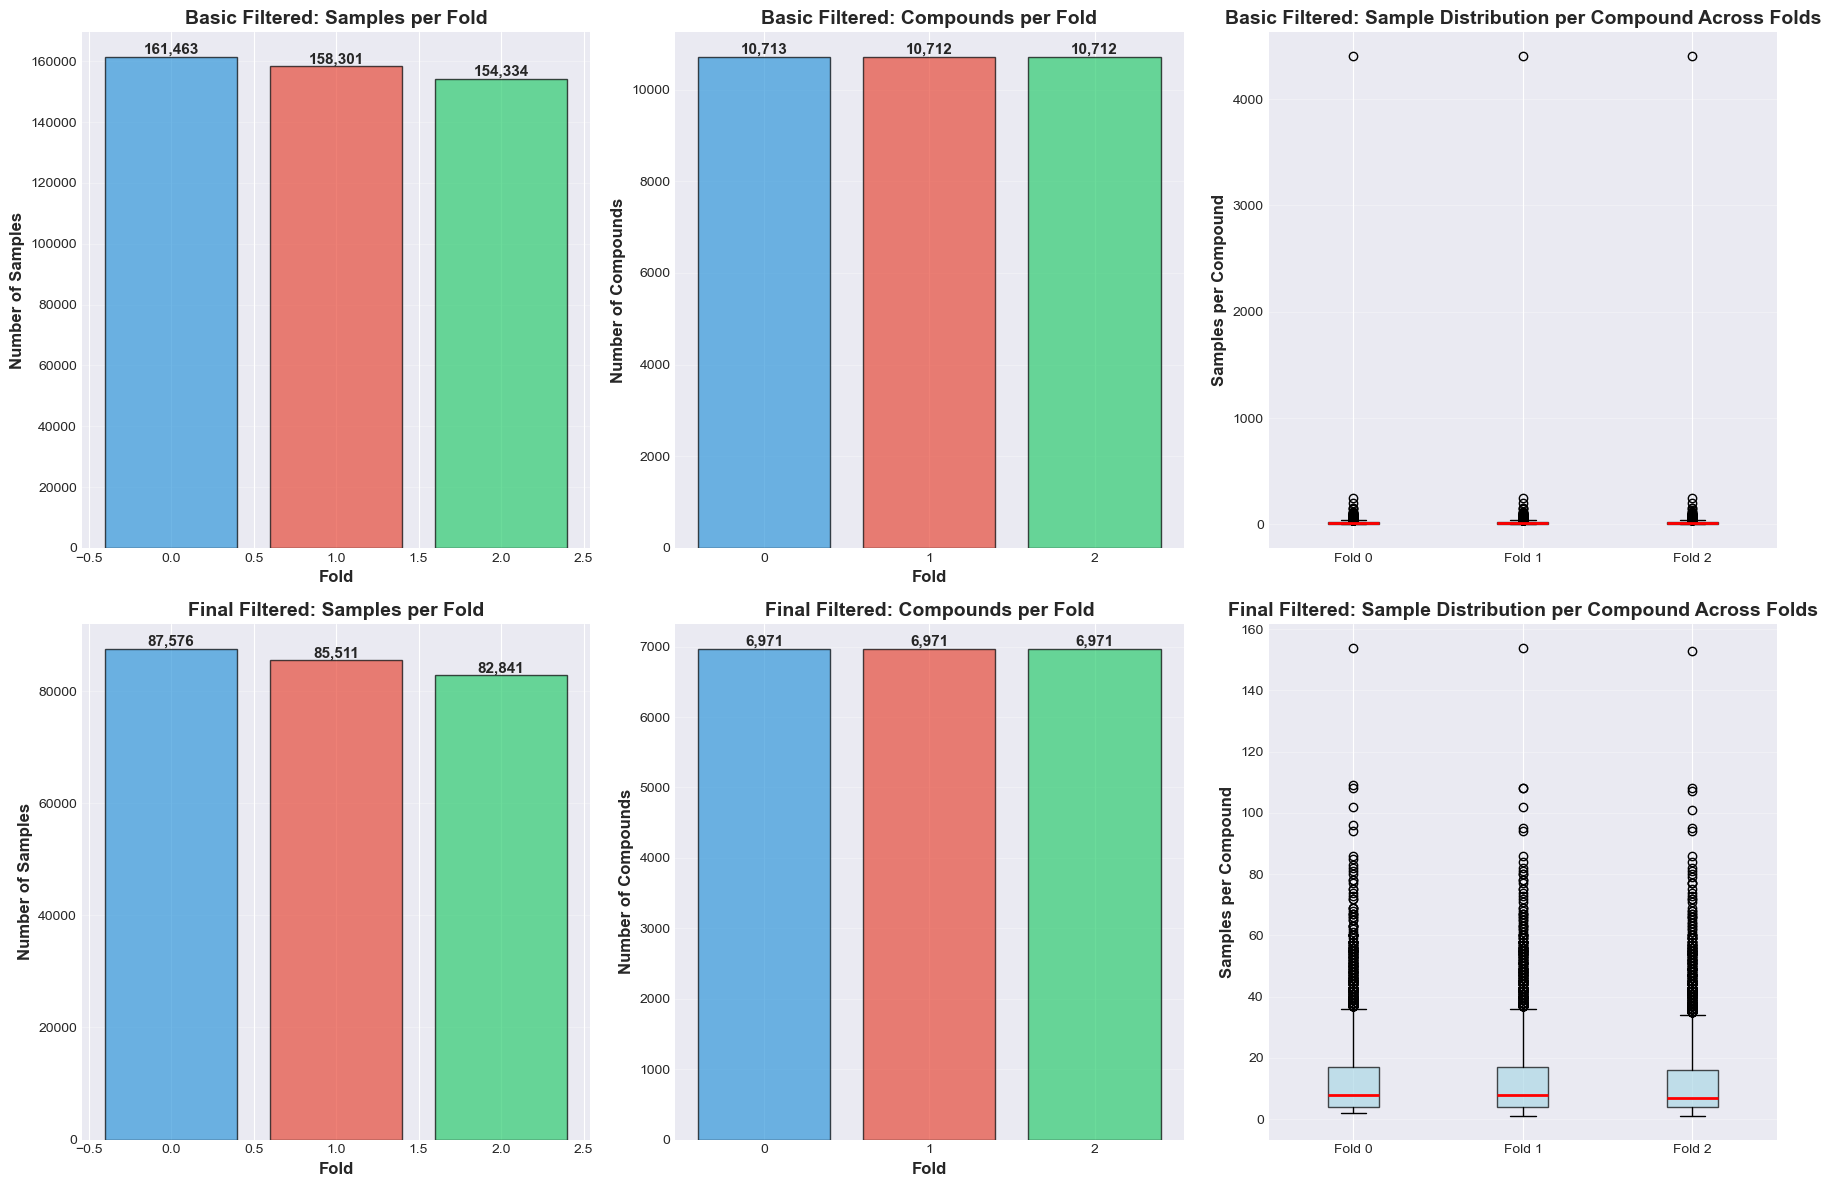


📊 Basic Filtered - Fold Statistics:
  Fold 0:
    Samples: 161,463 (34.1%)
    Compounds: 10,713
  Fold 1:
    Samples: 158,301 (33.4%)
    Compounds: 10,712
  Fold 2:
    Samples: 154,334 (32.6%)
    Compounds: 10,712

📊 Final Filtered - Fold Statistics:
  Fold 0:
    Samples: 87,576 (34.2%)
    Compounds: 6,971
  Fold 1:
    Samples: 85,511 (33.4%)
    Compounds: 6,971
  Fold 2:
    Samples: 82,841 (32.4%)
    Compounds: 6,971


In [7]:
# 分析fold分布
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

datasets = [('Basic Filtered', data_basic), ('Final Filtered', data_final)]

for row_idx, (dataset_name, data) in enumerate(datasets):
    folds = data['folds']
    metadata = data['sample_meta']
    
    # 子图1: Fold样本数分布
    ax = axes[row_idx, 0]
    fold_counts = pd.Series(folds).value_counts().sort_index()
    bars = ax.bar(fold_counts.index, fold_counts.values, color=['#3498db', '#e74c3c', '#2ecc71'], 
                  alpha=0.7, edgecolor='black')
    ax.set_xlabel('Fold', fontweight='bold')
    ax.set_ylabel('Number of Samples', fontweight='bold')
    ax.set_title(f'{dataset_name}: Samples per Fold', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # 添加数值标签
    for bar, val in zip(bars, fold_counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,}',
                ha='center', va='bottom', fontweight='bold')
    
    # 子图2: Fold化合物数分布
    ax = axes[row_idx, 1]
    fold_compound_counts = []
    for fold_id in sorted(np.unique(folds)):
        fold_mask = folds == fold_id
        n_compounds = metadata[fold_mask]['pert_id'].nunique()
        fold_compound_counts.append(n_compounds)
    
    bars = ax.bar(range(len(fold_compound_counts)), fold_compound_counts, 
                  color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
    ax.set_xlabel('Fold', fontweight='bold')
    ax.set_ylabel('Number of Compounds', fontweight='bold')
    ax.set_title(f'{dataset_name}: Compounds per Fold', fontweight='bold')
    ax.set_xticks(range(len(fold_compound_counts)))
    ax.grid(axis='y', alpha=0.3)
    
    # 添加数值标签
    for bar, val in zip(bars, fold_compound_counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,}',
                ha='center', va='bottom', fontweight='bold')
    
    # 子图3: 每个化合物在各fold的分布
    ax = axes[row_idx, 2]
    compound_fold_dist = []
    for compound in data['compound_names']:
        compound_mask = metadata['pert_id'] == compound
        compound_folds = folds[compound_mask]
        fold_dist = []
        for fold_id in range(3):
            fold_dist.append((compound_folds == fold_id).sum())
        compound_fold_dist.append(fold_dist)
    
    compound_fold_dist = np.array(compound_fold_dist)
    
    # 绘制箱线图
    bp = ax.boxplot([compound_fold_dist[:, i] for i in range(3)],
                     labels=['Fold 0', 'Fold 1', 'Fold 2'],
                     patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
    
    ax.set_ylabel('Samples per Compound', fontweight='bold')
    ax.set_title(f'{dataset_name}: Sample Distribution per Compound Across Folds', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / '05_cross_validation_folds.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印统计信息
for dataset_name, data in datasets:
    print(f"\n📊 {dataset_name} - Fold Statistics:")
    folds = data['folds']
    metadata = data['sample_meta']
    
    for fold_id in sorted(np.unique(folds)):
        fold_mask = folds == fold_id
        n_samples = fold_mask.sum()
        n_compounds = metadata[fold_mask]['pert_id'].nunique()
        print(f"  Fold {fold_id}:")
        print(f"    Samples: {n_samples:,} ({n_samples/len(folds)*100:.1f}%)")
        print(f"    Compounds: {n_compounds:,}")

## 7. 基因表达特征分析

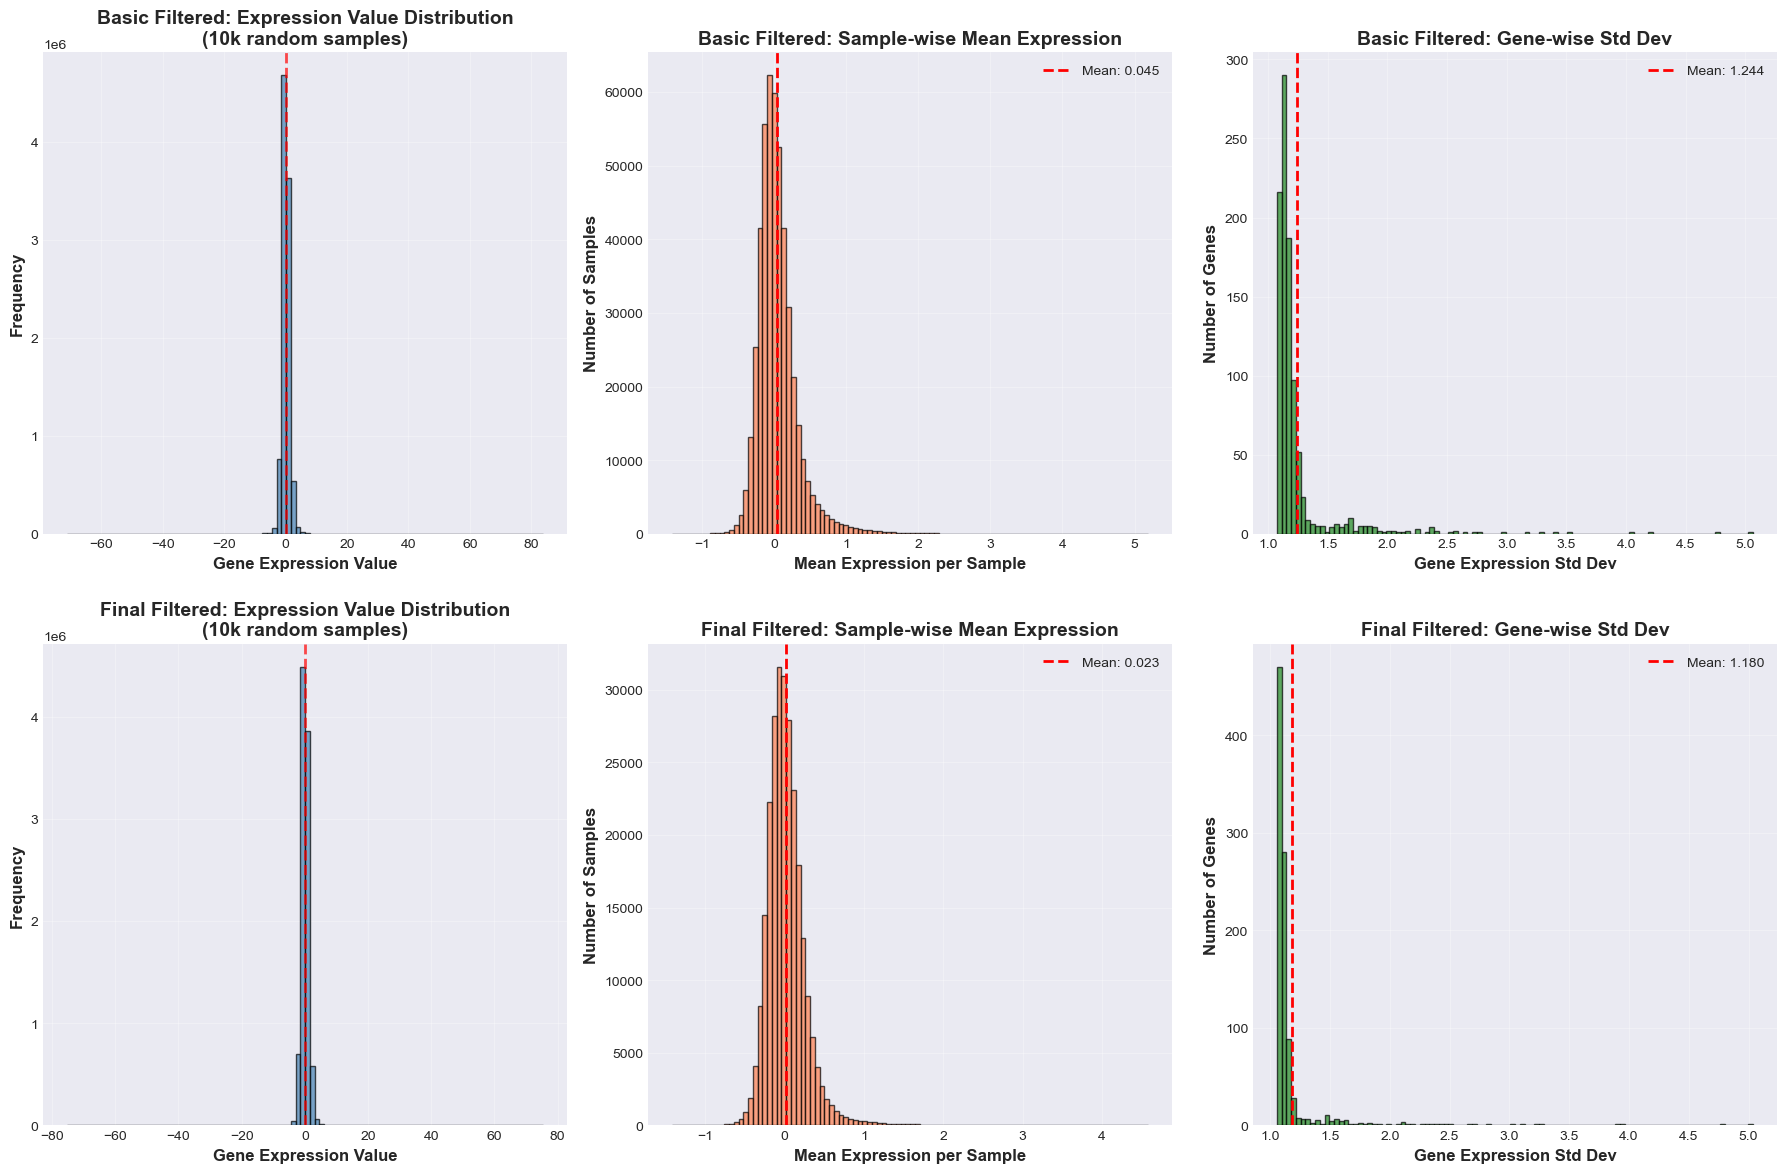


📊 Basic Filtered - Expression Statistics:
  Matrix shape: (474098, 978)
  Value range: [-101.174, 101.174]
  Mean: 0.045
  Std: 1.297
  Median: 0.004
  % zeros: 0.36%

📊 Final Filtered - Expression Statistics:
  Matrix shape: (255928, 978)
  Value range: [-101.174, 100.957]
  Mean: 0.023
  Std: 1.228
  Median: 0.000
  % zeros: 0.37%


In [8]:
# 分析基因表达值的分布
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

datasets = [('Basic Filtered', data_basic), ('Final Filtered', data_final)]

for row_idx, (dataset_name, data) in enumerate(datasets):
    X = data['X']
    
    # 子图1: 所有基因表达值分布
    ax = axes[row_idx, 0]
    sample_indices = np.random.choice(X.shape[0], min(10000, X.shape[0]), replace=False)
    sample_data = X[sample_indices].flatten()
    
    ax.hist(sample_data, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Gene Expression Value', fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.set_title(f'{dataset_name}: Expression Value Distribution\n(10k random samples)', fontweight='bold')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.grid(True, alpha=0.3)
    
    # 子图2: 每个样本的平均表达值
    ax = axes[row_idx, 1]
    sample_means = X.mean(axis=1)
    ax.hist(sample_means, bins=100, color='coral', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Mean Expression per Sample', fontweight='bold')
    ax.set_ylabel('Number of Samples', fontweight='bold')
    ax.set_title(f'{dataset_name}: Sample-wise Mean Expression', fontweight='bold')
    ax.axvline(sample_means.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {sample_means.mean():.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 子图3: 每个基因的标准差
    ax = axes[row_idx, 2]
    gene_stds = X.std(axis=0)
    ax.hist(gene_stds, bins=100, color='forestgreen', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Gene Expression Std Dev', fontweight='bold')
    ax.set_ylabel('Number of Genes', fontweight='bold')
    ax.set_title(f'{dataset_name}: Gene-wise Std Dev', fontweight='bold')
    ax.axvline(gene_stds.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {gene_stds.mean():.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / '06_gene_expression_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印统计信息
for dataset_name, data in datasets:
    X = data['X']
    print(f"\n📊 {dataset_name} - Expression Statistics:")
    print(f"  Matrix shape: {X.shape}")
    print(f"  Value range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"  Mean: {X.mean():.3f}")
    print(f"  Std: {X.std():.3f}")
    print(f"  Median: {np.median(X):.3f}")
    print(f"  % zeros: {(X == 0).sum() / X.size * 100:.2f}%")

## 8. 化学过滤效果对比


🧪 Chemical Filtering Impact:
  Compounds before: 10,713
  Compounds after: 6,971
  Removed: 3,742 (34.9%)


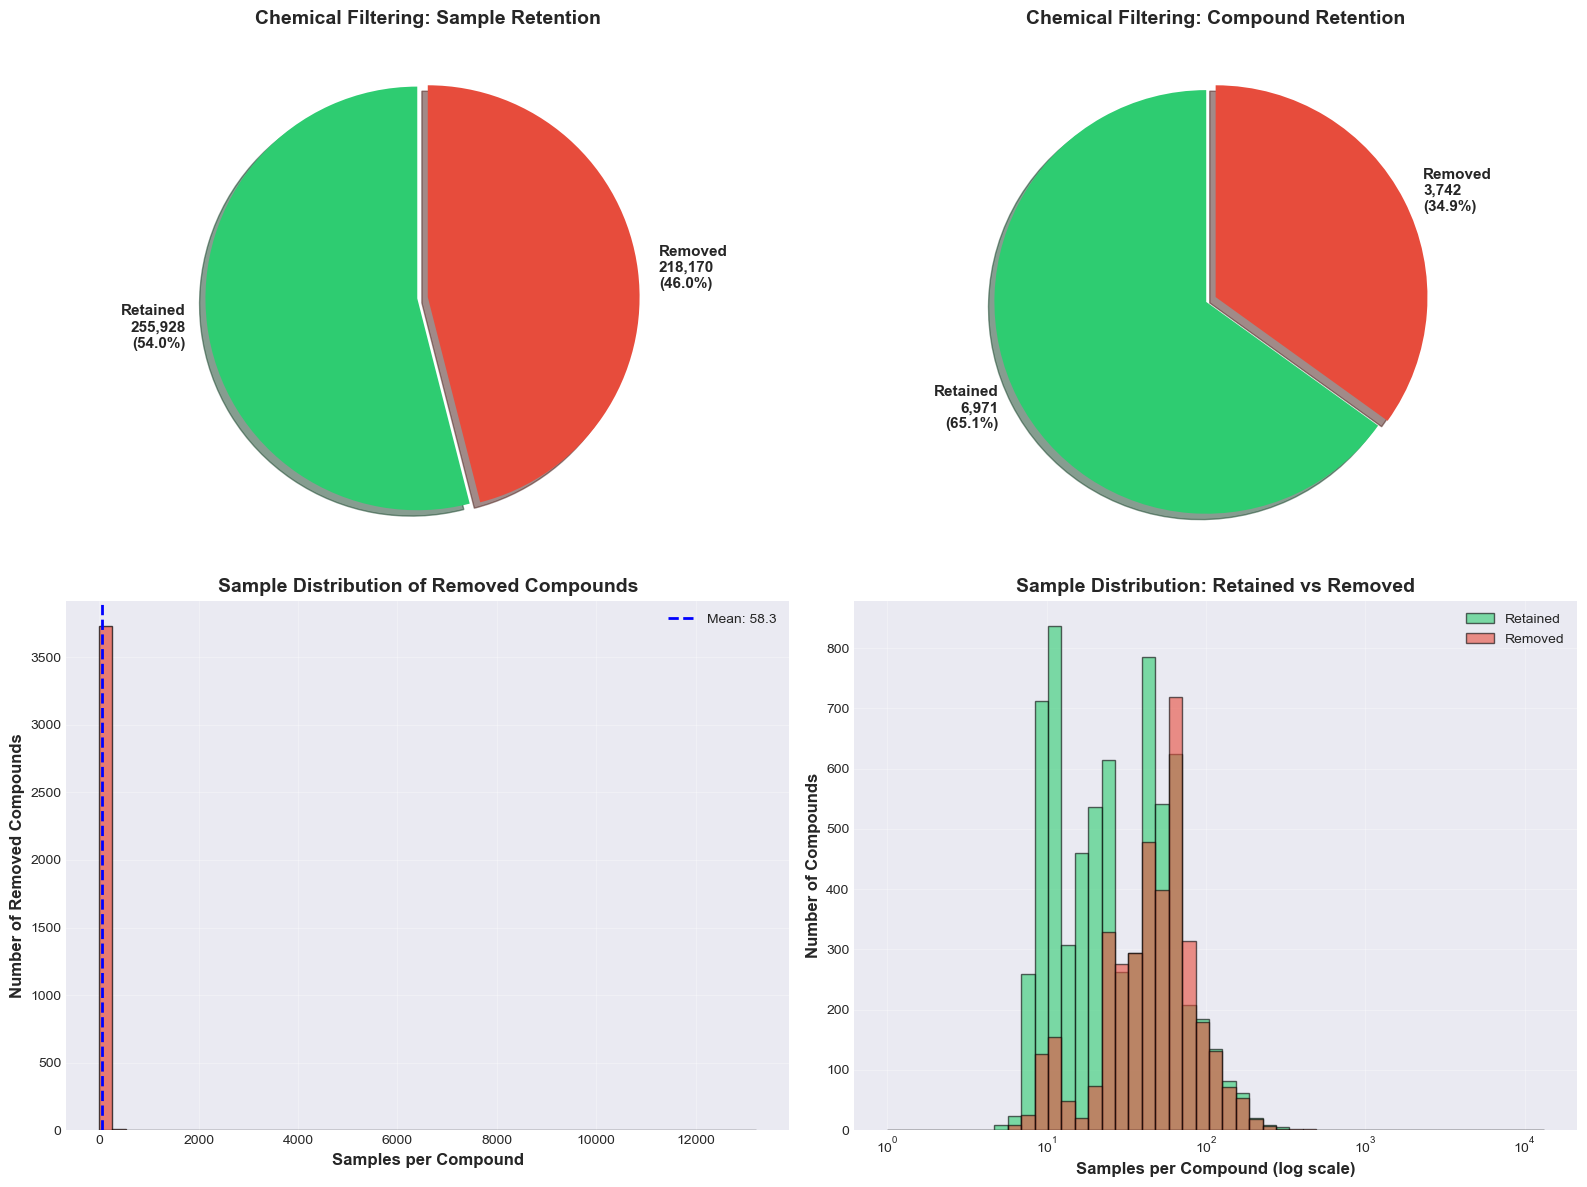


📊 Removed Compounds Statistics:
  Mean samples per compound: 58.3
  Median samples per compound: 50
  Min samples: 1
  Max samples: 13223
  Total samples removed: 218,170


In [9]:
# 准备对比数据
basic_compounds = set(data_basic['compound_names'])
final_compounds = set(data_final['compound_names'])
removed_compounds = basic_compounds - final_compounds

print(f"\n🧪 Chemical Filtering Impact:")
print(f"  Compounds before: {len(basic_compounds):,}")
print(f"  Compounds after: {len(final_compounds):,}")
print(f"  Removed: {len(removed_compounds):,} ({len(removed_compounds)/len(basic_compounds)*100:.1f}%)")

# 分析被移除化合物的特征
removed_sample_counts = []
for compound in removed_compounds:
    n_samples = (data_basic['sample_meta']['pert_id'] == compound).sum()
    removed_sample_counts.append(n_samples)

# 创建对比可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 子图1: 样本数对比（饼图）
ax = axes[0, 0]
basic_samples = len(data_basic['X'])
final_samples = len(data_final['X'])
removed_samples = basic_samples - final_samples

sizes = [final_samples, removed_samples]
labels = [f'Retained\n{final_samples:,}\n({final_samples/basic_samples*100:.1f}%)',
          f'Removed\n{removed_samples:,}\n({removed_samples/basic_samples*100:.1f}%)']
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='',
       shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Chemical Filtering: Sample Retention', fontweight='bold', fontsize=14)

# 子图2: 化合物数对比（饼图）
ax = axes[0, 1]
sizes = [len(final_compounds), len(removed_compounds)]
labels = [f'Retained\n{len(final_compounds):,}\n({len(final_compounds)/len(basic_compounds)*100:.1f}%)',
          f'Removed\n{len(removed_compounds):,}\n({len(removed_compounds)/len(basic_compounds)*100:.1f}%)']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='',
       shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Chemical Filtering: Compound Retention', fontweight='bold', fontsize=14)

# 子图3: 被移除化合物的样本数分布
ax = axes[1, 0]
ax.hist(removed_sample_counts, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax.set_xlabel('Samples per Compound', fontweight='bold')
ax.set_ylabel('Number of Removed Compounds', fontweight='bold')
ax.set_title('Sample Distribution of Removed Compounds', fontweight='bold')
ax.axvline(np.mean(removed_sample_counts), color='blue', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(removed_sample_counts):.1f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 子图4: 过滤前后样本数分布对比
ax = axes[1, 1]
retained_sample_counts = []
for compound in final_compounds:
    n_samples = (data_final['sample_meta']['pert_id'] == compound).sum()
    retained_sample_counts.append(n_samples)

# 对数bins
bins = np.logspace(0, np.log10(max(max(retained_sample_counts), max(removed_sample_counts))), 50)
ax.hist(retained_sample_counts, bins=bins, alpha=0.6, label='Retained', color='#2ecc71', edgecolor='black')
ax.hist(removed_sample_counts, bins=bins, alpha=0.6, label='Removed', color='#e74c3c', edgecolor='black')
ax.set_xscale('log')
ax.set_xlabel('Samples per Compound (log scale)', fontweight='bold')
ax.set_ylabel('Number of Compounds', fontweight='bold')
ax.set_title('Sample Distribution: Retained vs Removed', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / '07_chemical_filtering_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印详细统计
print(f"\n📊 Removed Compounds Statistics:")
print(f"  Mean samples per compound: {np.mean(removed_sample_counts):.1f}")
print(f"  Median samples per compound: {np.median(removed_sample_counts):.0f}")
print(f"  Min samples: {np.min(removed_sample_counts)}")
print(f"  Max samples: {np.max(removed_sample_counts)}")
print(f"  Total samples removed: {sum(removed_sample_counts):,}")

## 9. 综合对比总结

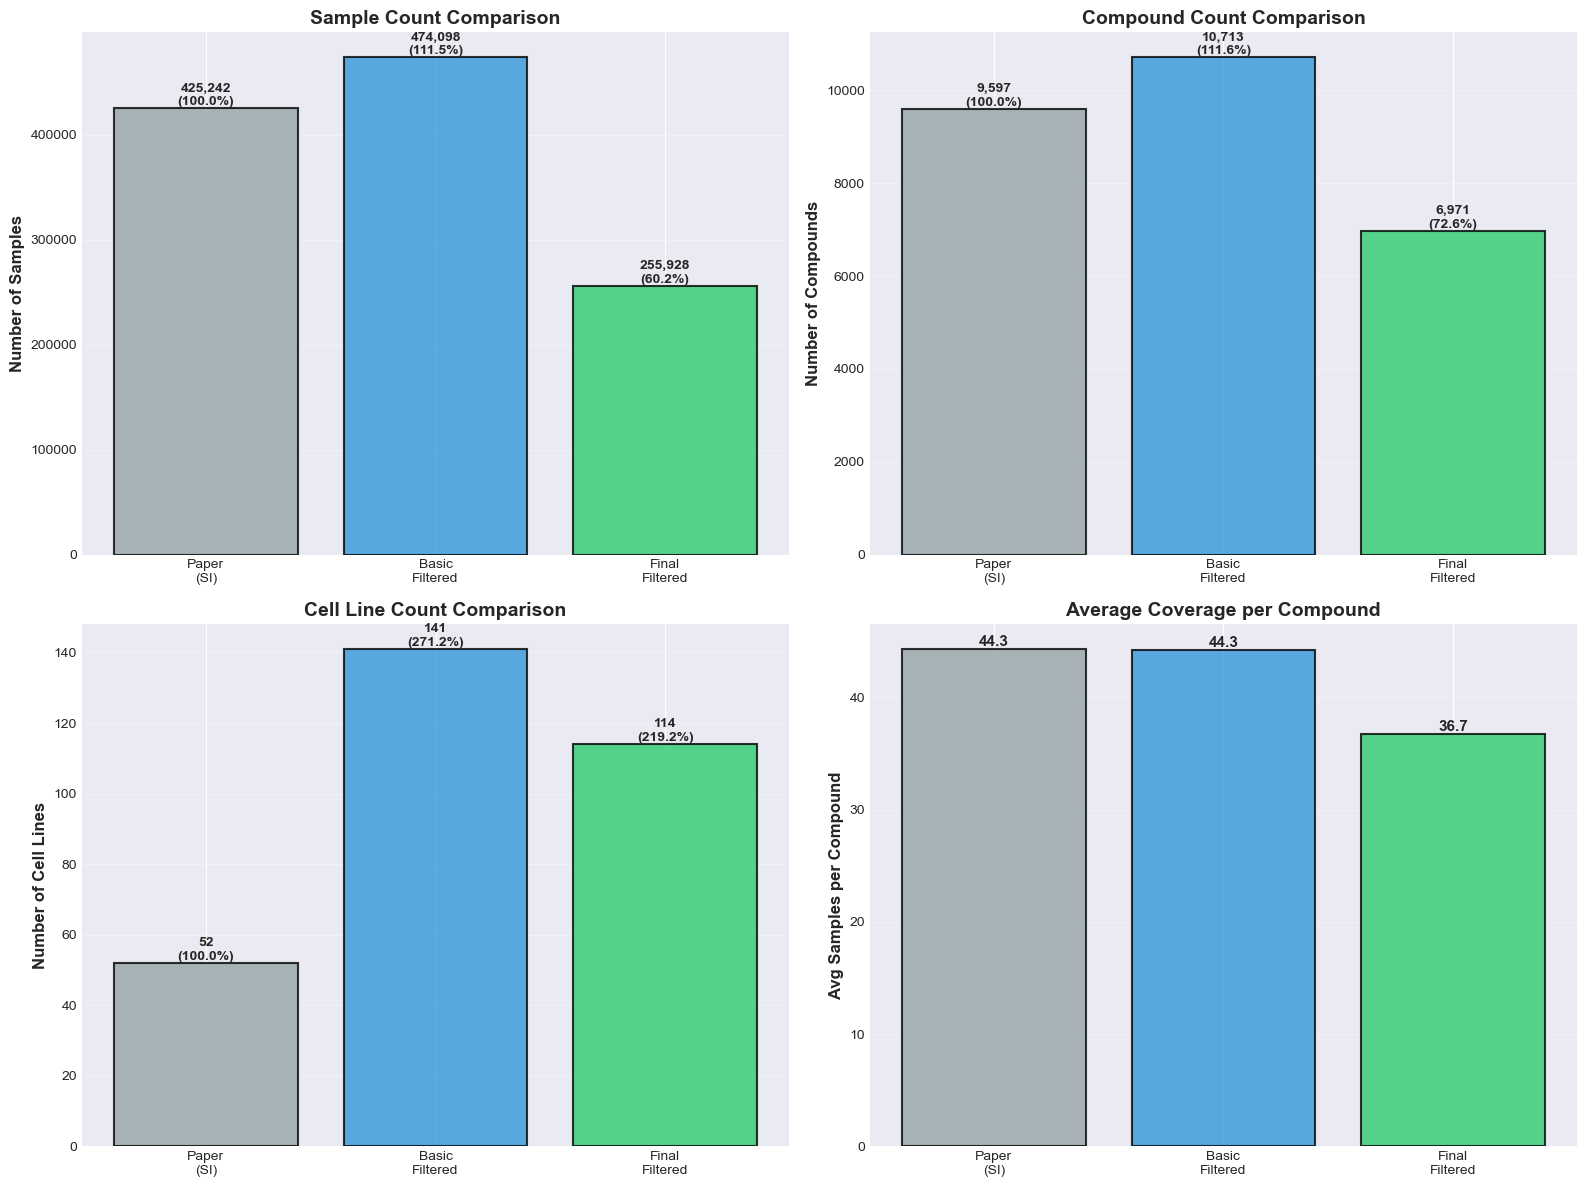


📊 FINAL DATASET SUMMARY

✓ All visualizations saved to: E:\科研\Models\drugreflector\visualizations

📈 Dataset Progression:
  Paper (SI) → Basic Filtered → Final Filtered
  425,242 → 474,098 → 255,928 samples
  9,597 → 10,713 → 6,971 compounds
  52 → 141 → 114 cell lines

🎯 Final retention rates (vs Paper):
  Samples: 60.2%
  Compounds: 72.6%

✅ Visualization complete!


In [10]:
# 创建综合对比图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 子图1: 样本数对比柱状图
ax = axes[0, 0]
datasets = ['Paper\n(SI)', 'Basic\nFiltered', 'Final\nFiltered']
samples = [425242, len(data_basic['X']), len(data_final['X'])]
colors_bar = ['#95a5a6', '#3498db', '#2ecc71']

bars = ax.bar(datasets, samples, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Samples', fontweight='bold', fontsize=12)
ax.set_title('Sample Count Comparison', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

# 添加数值标签和百分比
for i, (bar, val) in enumerate(zip(bars, samples)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}\n({val/samples[0]*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# 子图2: 化合物数对比柱状图
ax = axes[0, 1]
compounds = [9597, len(data_basic['compound_names']), len(data_final['compound_names'])]

bars = ax.bar(datasets, compounds, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Compounds', fontweight='bold', fontsize=12)
ax.set_title('Compound Count Comparison', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

# 添加数值标签和百分比
for i, (bar, val) in enumerate(zip(bars, compounds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}\n({val/compounds[0]*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# 子图3: 细胞系数对比
ax = axes[1, 0]
if 'cell_iname' in data_basic['sample_meta'].columns:
    cells = [52, 
             data_basic['sample_meta']['cell_iname'].nunique(),
             data_final['sample_meta']['cell_iname'].nunique()]
    
    bars = ax.bar(datasets, cells, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Number of Cell Lines', fontweight='bold', fontsize=12)
    ax.set_title('Cell Line Count Comparison', fontweight='bold', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    
    # 添加数值标签和百分比
    for i, (bar, val) in enumerate(zip(bars, cells)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val}\n({val/cells[0]*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
else:
    ax.text(0.5, 0.5, 'Cell line data\nnot available', 
            ha='center', va='center', transform=ax.transAxes, fontsize=14)

# 子图4: 平均每化合物样本数
ax = axes[1, 1]
avg_samples = [samples[i]/compounds[i] for i in range(3)]

bars = ax.bar(datasets, avg_samples, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Avg Samples per Compound', fontweight='bold', fontsize=12)
ax.set_title('Average Coverage per Compound', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

# 添加数值标签
for bar, val in zip(bars, avg_samples):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(viz_dir / '08_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印最终总结
print("\n" + "="*80)
print("📊 FINAL DATASET SUMMARY")
print("="*80)
print(f"\n✓ All visualizations saved to: {viz_dir}")
print(f"\n📈 Dataset Progression:")
print(f"  Paper (SI) → Basic Filtered → Final Filtered")
print(f"  {samples[0]:,} → {samples[1]:,} → {samples[2]:,} samples")
print(f"  {compounds[0]:,} → {compounds[1]:,} → {compounds[2]:,} compounds")
if 'cell_iname' in data_basic['sample_meta'].columns:
    print(f"  {cells[0]} → {cells[1]} → {cells[2]} cell lines")
print(f"\n🎯 Final retention rates (vs Paper):")
print(f"  Samples: {samples[2]/samples[0]*100:.1f}%")
print(f"  Compounds: {compounds[2]/compounds[0]*100:.1f}%")
print(f"\n✅ Visualization complete!")

## 10. 额外分析：时间点和剂量分布（如果可用）

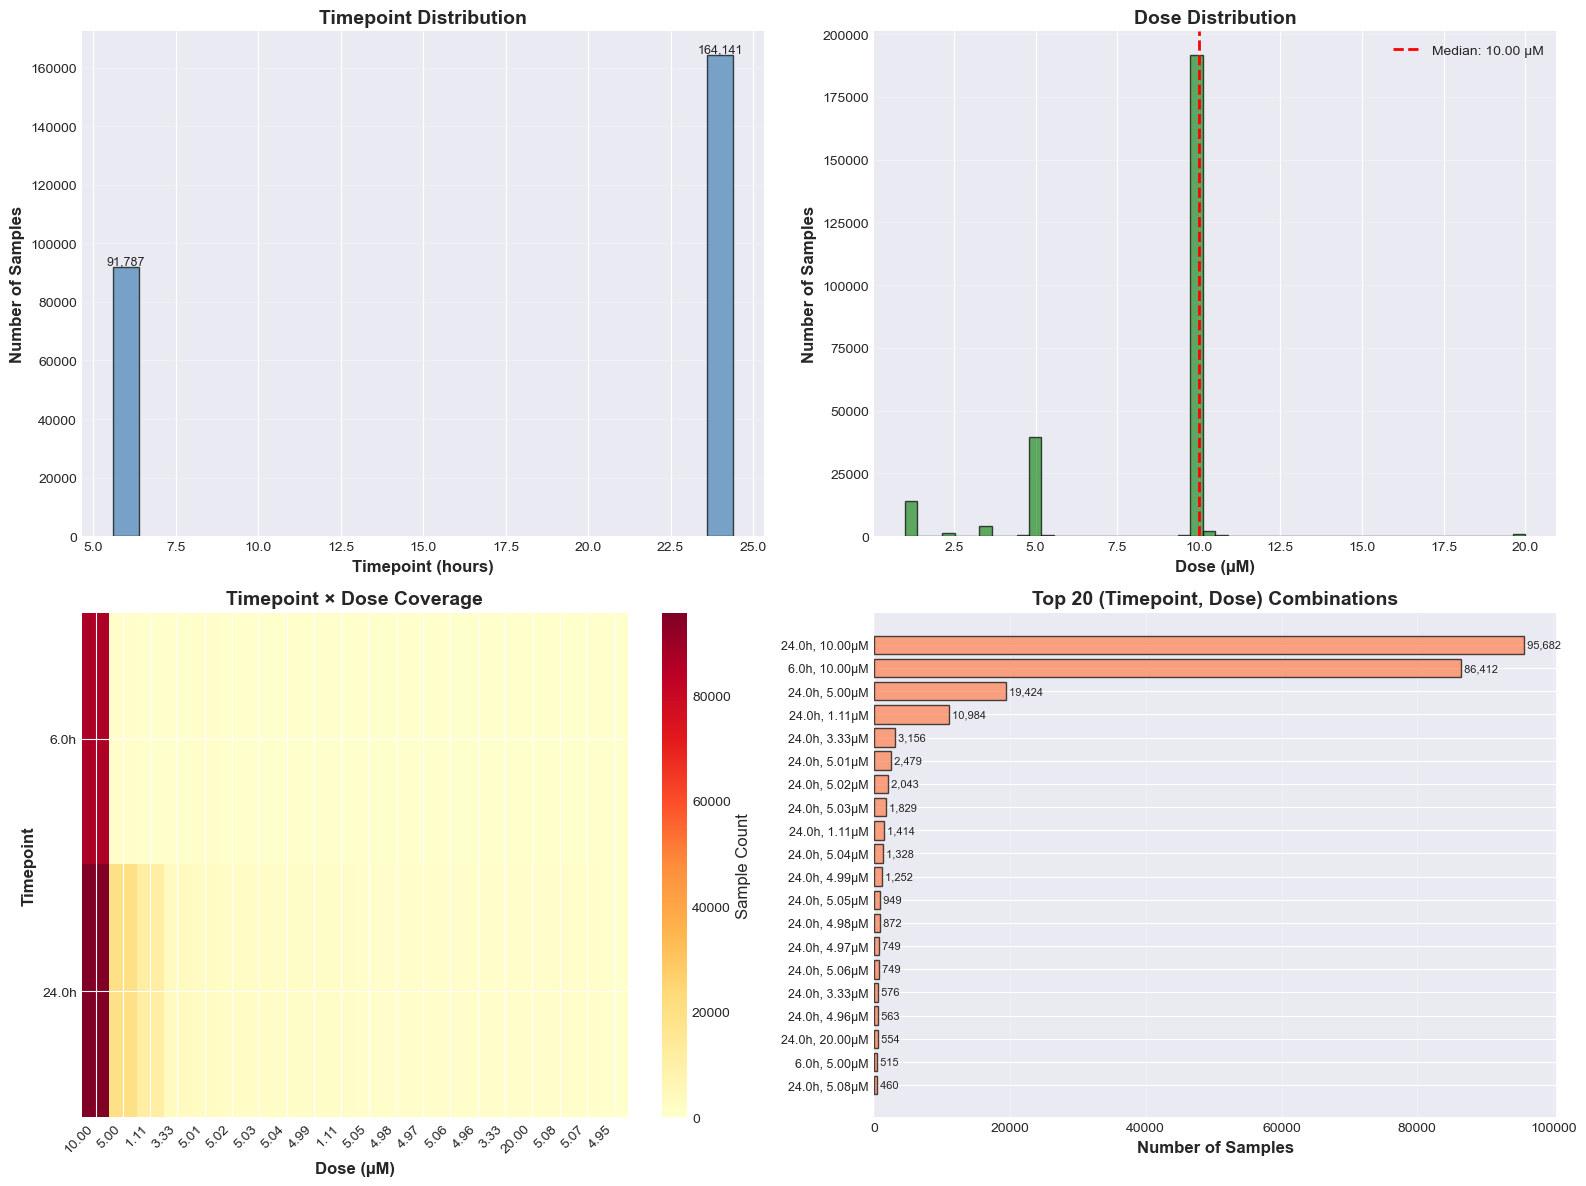


📊 Timepoint & Dose Statistics:
  Unique timepoints: 2
  Timepoint range: 6.0 - 24.0 hours
  Unique doses: 729
  Dose range: 1.000 - 20.000 µM


In [11]:
# 检查是否有时间点和剂量信息
if 'pert_time' in data_final['sample_meta'].columns and 'pert_dose' in data_final['sample_meta'].columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metadata = data_final['sample_meta']
    
    # 子图1: 时间点分布
    ax = axes[0, 0]
    time_numeric = pd.to_numeric(metadata['pert_time'], errors='coerce')
    time_counts = time_numeric.value_counts().sort_index()
    
    bars = ax.bar(time_counts.index, time_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Timepoint (hours)', fontweight='bold')
    ax.set_ylabel('Number of Samples', fontweight='bold')
    ax.set_title('Timepoint Distribution', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # 添加数值标签
    for bar, val in zip(bars, time_counts.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,}',
                ha='center', va='bottom', fontsize=9)
    
    # 子图2: 剂量分布（如果有dose_uM列）
    ax = axes[0, 1]
    if 'dose_uM' in metadata.columns:
        dose_values = metadata['dose_uM'].dropna()
        ax.hist(dose_values, bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Dose (µM)', fontweight='bold')
        ax.set_ylabel('Number of Samples', fontweight='bold')
        ax.set_title('Dose Distribution', fontweight='bold')
        ax.axvline(dose_values.median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: {dose_values.median():.2f} µM')
        ax.legend()
    else:
        # 尝试从pert_dose解析
        dose_str = metadata['pert_dose'].astype(str)
        dose_numeric = pd.to_numeric(dose_str.str.extract(r'([\d.]+)', expand=False), errors='coerce')
        dose_numeric = dose_numeric.dropna()
        
        ax.hist(dose_numeric, bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Dose (parsed value)', fontweight='bold')
        ax.set_ylabel('Number of Samples', fontweight='bold')
        ax.set_title('Dose Distribution', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # 子图3: 时间点 × 剂量 热图
    ax = axes[1, 0]
    if 'dose_uM' in metadata.columns:
        # 创建时间-剂量矩阵
        time_dose_pivot = metadata.pivot_table(
            values='pert_id',
            index='pert_time',
            columns='dose_uM',
            aggfunc='count',
            fill_value=0
        )
        
        # 只显示前20个剂量
        if time_dose_pivot.shape[1] > 20:
            top_doses = metadata['dose_uM'].value_counts().head(20).index
            time_dose_pivot = time_dose_pivot[top_doses]
        
        im = ax.imshow(time_dose_pivot.values, cmap='YlOrRd', aspect='auto')
        ax.set_xticks(np.arange(len(time_dose_pivot.columns)))
        ax.set_yticks(np.arange(len(time_dose_pivot.index)))
        ax.set_xticklabels([f"{d:.2f}" for d in time_dose_pivot.columns], rotation=45, ha='right')
        ax.set_yticklabels([f"{t}h" for t in time_dose_pivot.index])
        ax.set_xlabel('Dose (µM)', fontweight='bold')
        ax.set_ylabel('Timepoint', fontweight='bold')
        ax.set_title('Timepoint × Dose Coverage', fontweight='bold')
        
        plt.colorbar(im, ax=ax, label='Sample Count')
    else:
        ax.text(0.5, 0.5, 'Dose data\nnot available', 
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
    
    # 子图4: 样本数最多的时间-剂量组合
    ax = axes[1, 1]
    if 'dose_uM' in metadata.columns:
        time_dose_counts = metadata.groupby(['pert_time', 'dose_uM']).size().sort_values(ascending=False).head(20)
        
        labels = [f"{t}h, {d:.2f}µM" for (t, d) in time_dose_counts.index]
        y_pos = np.arange(len(labels))
        
        bars = ax.barh(y_pos, time_dose_counts.values, color='coral', alpha=0.7, edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_xlabel('Number of Samples', fontweight='bold')
        ax.set_title('Top 20 (Timepoint, Dose) Combinations', fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        ax.invert_yaxis()
        
        # 添加数值标签
        for i, (bar, val) in enumerate(zip(bars, time_dose_counts.values)):
            ax.text(val, i, f' {val:,}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(viz_dir / '09_timepoint_dose_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Timepoint & Dose Statistics:")
    print(f"  Unique timepoints: {time_numeric.nunique()}")
    print(f"  Timepoint range: {time_numeric.min():.1f} - {time_numeric.max():.1f} hours")
    if 'dose_uM' in metadata.columns:
        print(f"  Unique doses: {metadata['dose_uM'].nunique()}")
        print(f"  Dose range: {metadata['dose_uM'].min():.3f} - {metadata['dose_uM'].max():.3f} µM")
else:
    print("\n⚠️  Timepoint or dose information not available in metadata")

## 总结

所有可视化图表已保存到指定目录。本notebook提供了以下分析：

1. **数据集基本统计** - 与论文数据的全面对比
2. **化合物样本分布** - 样本覆盖度和Top化合物分析
3. **细胞系分布** - 细胞系覆盖度和使用频率
4. **化合物-细胞系矩阵** - 数据覆盖的全景视图
5. **交叉验证Fold** - 数据划分的平衡性分析
6. **基因表达特征** - 表达值分布和变异性
7. **化学过滤效果** - 过滤前后的详细对比
8. **综合对比总结** - 整体数据质量评估
9. **时间点和剂量** - 实验条件分布（如果可用）

这些可视化有助于：
- 理解数据预处理的效果
- 评估数据质量和覆盖度
- 为模型训练提供数据洞察
- 与论文结果进行对比验证